In [25]:
from math import cos, exp, pi, tanh, sqrt
from scipy.integrate import quad, dblquad
from scipy.misc import derivative
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def phi(x):
    #we choose what our activation function is going to be here
    return tanh(x)

def normDist(z):
    #this is for the intergral measures
    return (1/sqrt(2*pi))*exp(-(z**2)/2)

def qSSnext(sigmaW, sigmaB, qSSprev):
    #gives us the length of our vector given our parameters and the previous length
    def f(z):
        return (phi(sqrt(qSSprev)*z)**2) * normDist(z)

    range = 10
    intergral = quad(f, -range, range)
    return (sigmaW**2) * intergral[0] + (sigmaB**2)


def qSSstar(sigmaW, sigmaB, qSSprev):
    #works out the limiting length of the vector given the previous length and the parameters
    #we're assume the limit is reached within 30 steps
    qSStemp = qSSprev
    for i in range(30):
        qSStemp = qSSnext(sigmaW, sigmaB, qSStemp)

    return qSStemp

def qAB_next(sigmaW, sigmaB, qAA_prev, qBB_prev, corr_prev):
    #this is for calculating the joint correlation
    #we dont have to assume the vector lengths qAA qBB have reached their limit -
    # but turns out that we will actually just input the limited qAA to make our results input independent

    def u1(z1):
        return sqrt(qAA_prev)*z1

    def u2(z1, z2):
        return sqrt(qBB_prev)*(corr_prev*z1 + sqrt(1- corr_prev**2)*z2)

    def f(z1, z2):
        return phi(u1(z1))*phi(u2(z1, z2))*normDist(z1)*normDist(z2)

    range = 10
    intergral = dblquad(f, -range, range, -range, range)

    return (sigmaW**2) * intergral[0] + (sigmaB**2)


def corr_map(sigmaW, sigmaB, corr_prev):
    #so we get the the new correlation, given a correlation, the only other things
    #that matter are the sigmas, since we just use the convergent length, that only depends on sigmaW sigmaB

    some_random_length = 10 # doesn't make a difference as qSSstar limits to same value
    qSSstar_val = qSSstar(sigmaW, sigmaB, some_random_length)

    q_AB = qAB_next(sigmaW, sigmaB, qSSstar_val, qSSstar_val, corr_prev)

    return (q_AB / qSSstar_val)

#this numpy move lets us apply the correlation map element wise to a vector
corr_map_vec = np.vectorize(corr_map, excluded=['sigmaW', 'sigmaB'])

def corr_map_plot(sigmaW, sigmaB, steps = 0.025):
    x = np.arange(0, 1, steps)
    y = corr_map_vec(sigmaW, sigmaB, x)
    plt.plot (x, y, 'bo')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()

print("set up complete")

set up complete


In [33]:
# we want to calculate the derivative of the correlation map
# we're going to first focus on just the derivative at the point 1
# but later, in the drop-out case, we will need to think more deeply as 1 wont be a fix point

def deriv_cmap(sigmaW, sigmaB, deriv_point=1):
    print(sigmaW, sigmaB)
    #looking at (17) in Poole, this turns out to be very similar to the qAB function
    some_random_length = 10 # doesn't make a difference as qSSstar limits to same value
    qSSstar_val = qSSstar(sigmaW, sigmaB, some_random_length)

    def u1(z1):
        return sqrt(qSSstar_val)*z1

    def u2(z1, z2):
        return sqrt(qSSstar_val)*(deriv_point*z1 + sqrt(1- deriv_point**2)*z2)

    def deriv_phi(x0):
        return derivative(phi, x0, dx = 0.01)

    def f(z1, z2):
        return deriv_phi(u1(z1))*deriv_phi(u2(z1, z2))*normDist(z1)*normDist(z2)

    range = 10
    intergral = dblquad(f, -range, range, -range, range)

    return (sigmaW**2) * intergral[0]

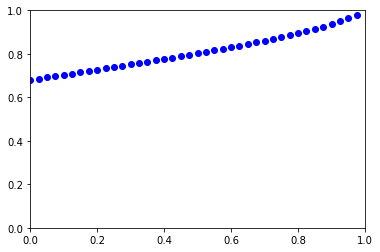

3 4


0.9799000895560948

In [34]:
corr_map_plot(3, 4, steps = 0.025)
deriv_cmap(3, 4, 1)

In [36]:
sigmaW_range = np.linspace(0.001, 4, 10)
sigmaB_range = np.linspace(0.001, 4, 10)
X, Y = np.meshgrid(sigmaW_range, sigmaB_range)

deriv_cmap_vec = np.vectorize(deriv_cmap, excluded = ["deriv_point"])
Z = deriv_cmap_vec(X, Y, deriv_point = 1)

0.001 0.001
0.001 0.001
0.44533333333333336 0.001
0.8896666666666667 0.001
1.334 0.001
1.7783333333333333 0.001
2.2226666666666666 0.001
2.6670000000000003 0.001
3.1113333333333335 0.001
3.5556666666666668 0.001
4.0 0.001
0.001 0.44533333333333336
0.44533333333333336 0.44533333333333336
0.8896666666666667 0.44533333333333336
1.334 0.44533333333333336
1.7783333333333333 0.44533333333333336
2.2226666666666666 0.44533333333333336
2.6670000000000003 0.44533333333333336
3.1113333333333335 0.44533333333333336
3.5556666666666668 0.44533333333333336
4.0 0.44533333333333336
0.001 0.8896666666666667
0.44533333333333336 0.8896666666666667
0.8896666666666667 0.8896666666666667
1.334 0.8896666666666667
1.7783333333333333 0.8896666666666667
2.2226666666666666 0.8896666666666667
2.6670000000000003 0.8896666666666667
3.1113333333333335 0.8896666666666667
3.5556666666666668 0.8896666666666667
4.0 0.8896666666666667
0.001 1.334
0.44533333333333336 1.334
0.8896666666666667 1.334
1.334 1.334
1.77833333333

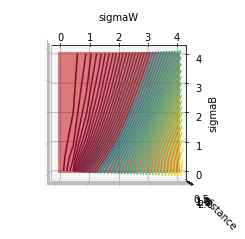

In [59]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50)
ax.set_xlabel('sigmaW')
ax.set_ylabel('sigmaB')
ax.set_zlabel('distance')

xx, yy = np.meshgrid(range(0,5, 1), range(0,5,1))
zz = xx*0 + yy*0 + 1

ax.plot_surface(xx, yy, zz, alpha=0.5, color="red")

ax.view_init(90, -90)

In [60]:
Z

array([[9.99931337e-07, 1.98308062e-01, 7.91274745e-01, 1.07602768e+00,
        1.25960931e+00, 1.46989866e+00, 1.69072238e+00, 1.91678749e+00,
        2.14583440e+00, 2.37673624e+00],
       [7.55207123e-07, 1.44916180e-01, 5.08569465e-01, 8.79988674e-01,
        1.16320045e+00, 1.41106855e+00, 1.64959706e+00, 1.88554452e+00,
        2.12078195e+00, 2.35588604e+00],
       [5.06776314e-07, 9.73038250e-02, 3.51735052e-01, 6.74024663e-01,
        9.89146382e-01, 1.27733836e+00, 1.54551596e+00, 1.80190861e+00,
        2.05151160e+00, 2.29706061e+00],
       [3.67472468e-07, 7.11782814e-02, 2.65136869e-01, 5.35295750e-01,
        8.33107836e-01, 1.12924896e+00, 1.41400713e+00, 1.68728058e+00,
        1.95153444e+00, 2.20920096e+00],
       [2.85103451e-07, 5.55925024e-02, 2.11220914e-01, 4.39780521e-01,
        7.09397477e-01, 9.94653219e-01, 1.28080194e+00, 1.56162214e+00,
        1.83558264e+00, 2.10310711e+00],
       [2.31925681e-07, 4.54249908e-02, 1.74822117e-01, 3.71201144e-01,
   